<a href="https://colab.research.google.com/github/mbarcodia/enso_prediction_tools/blob/main/Predict_ENSO_classification_w_lead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a neural network to predict the ENSO class

##### SST mean data downloaded from NOAA NCEI Extended Reconstructed Sea Surface Temperature
* https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html

##### Nino34 Index calculation computed generally following below website, but included detrending data
* https://foundations.projectpythia.org/core/xarray/enso-xarray.html

In [1]:
%pip install seaborn cartopy fsspec requests aiohttp h5netcdf

import xarray as xr
import fsspec
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.colors as mcolors

import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import seaborn as sns
from sklearn.metrics import confusion_matrix

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Set random seed for reproducibility
random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)


# 1. Load and Inspect Data

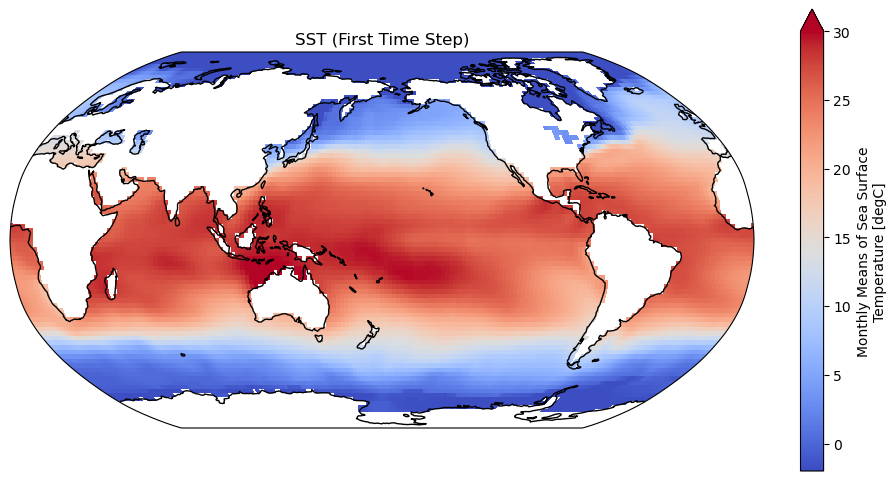

In [3]:
# Download SST dataset
url = "https://downloads.psl.noaa.gov/Datasets/noaa.ersst.v5/sst.mnmean.nc"
sst_data_raw = xr.open_dataset(fsspec.open(url).open())
sst_ds = sst_data_raw.sst

# Plot the first time step of the SST data
fig = plt.figure(figsize=(12, 6))
ax = plt.axes(projection=ccrs.Robinson(central_longitude=180))
ax.coastlines()
sst_ds.isel(time=0).plot(
    ax=ax, transform=ccrs.PlateCarree(), vmin=-2, vmax=30, cmap="coolwarm"
)
plt.title("SST (First Time Step)")
plt.show()

# 2. Define Data Splits

In [4]:
lead = 1  # number of months ahead to predict

exp_name = "enso_classification_lead" + str(lead)

# Define the training, validation, and testing periods
train_start, train_end = "1854-01-01", "1980-03-01"
val_start, val_end = "1980-09-01", "2001-03-01"
test_start, test_end = "2001-09-01", "2024-10-01"

# If the data split is sequential, defining the y-masks isn't necessary
# But if time periods are skipped between skips, this is needed
# This needs to be updated based on the lead time
train_start_y, train_end_y = "1854-02-01", "1980-04-01"
val_start_y, val_end_y = "1980-10-01", "2001-04-01"
test_start_y, test_end_y = "2001-10-01", "2024-11-01"

# Split the data into training, validation, and testing sets
train_data = sst_ds.sel(time=slice(train_start, train_end))
val_data = sst_ds.sel(time=slice(val_start, val_end))
test_data = sst_ds.sel(time=slice(test_start, test_end))

# 3. Compute and Remove Monthly Climatology

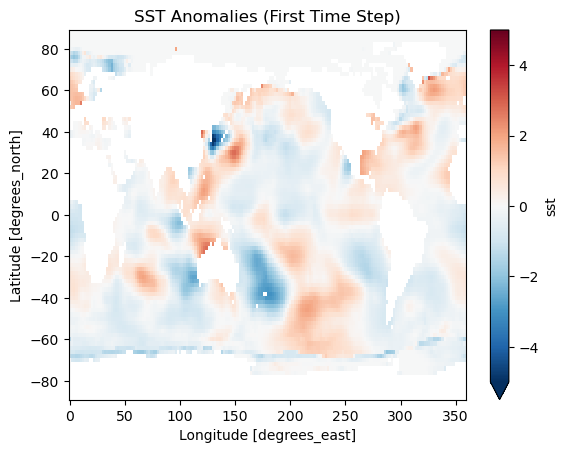

In [5]:
# Compute climatology (1950–1979 baseline period, within training period)
climo_period = train_data.sel(time=slice("1950-01-01", "1979-12-01"))
# climo_period = sst_ds.sel(time=slice("1990-01-01", "2019-12-01"))
climatology = climo_period.groupby("time.month").mean(dim="time")

# Remove climatology to calculate anomalies
sst_anomalies = sst_ds.groupby("time.month") - climatology

# Plot anomalies for verification
sst_anomalies.isel(time=0).plot(vmin=-5, vmax=5, cmap="RdBu_r")
plt.title("SST Anomalies (First Time Step)")
plt.show()

# 4. Extract Nino 3.4 Region

Text(0.5, 1.0, 'Niño 3.4 Index Phases')

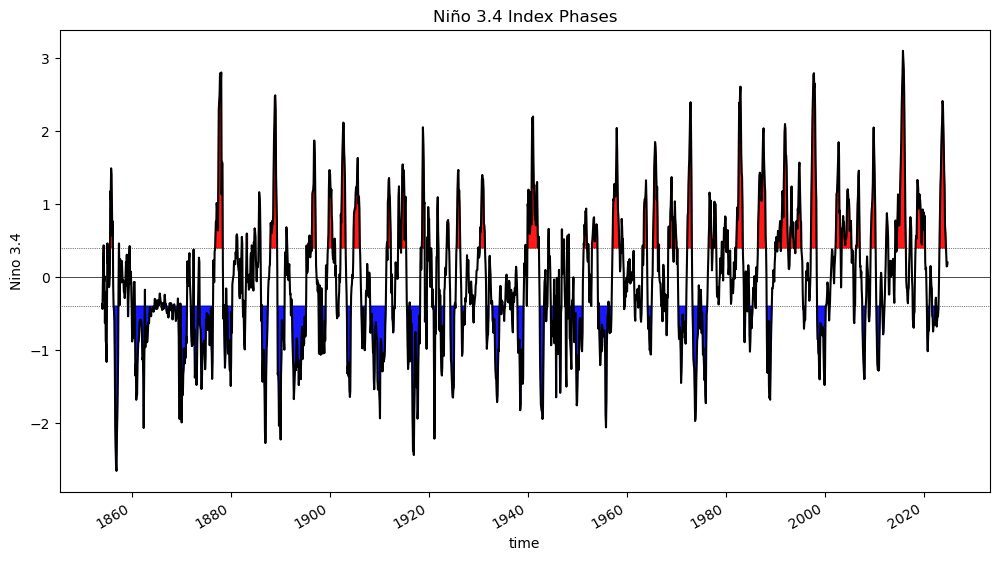

In [6]:
# Define Nino 3.4 region (5°N–5°S, 170°W–120°W)
nino34_region = sst_anomalies.sel(lat=slice(5, -5), lon=slice(190, 240))

# Compute area-weighted average SST anomalies over Nino 3.4 region
weights = np.cos(np.deg2rad(nino34_region["lat"]))
nino34_index = nino34_region.weighted(weights).mean(("lon", "lat"))

fig = plt.figure(figsize=(12, 6))

plt.fill_between(
    nino34_index.time.data,
    nino34_index.where(nino34_index >= 0.4).data,
    0.4,
    color="red",
    alpha=0.9,
)
plt.fill_between(
    nino34_index.time.data,
    nino34_index.where(nino34_index <= -0.4).data,
    -0.4,
    color="blue",
    alpha=0.9,
)

nino34_index.plot(color="black")
plt.ylabel("Nino 3.4")
plt.axhline(0, color="black", lw=0.5)
plt.axhline(0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.axhline(-0.4, color="black", linewidth=0.5, linestyle="dotted")
plt.title("Niño 3.4 Index Phases")

# 5. Detrend Data

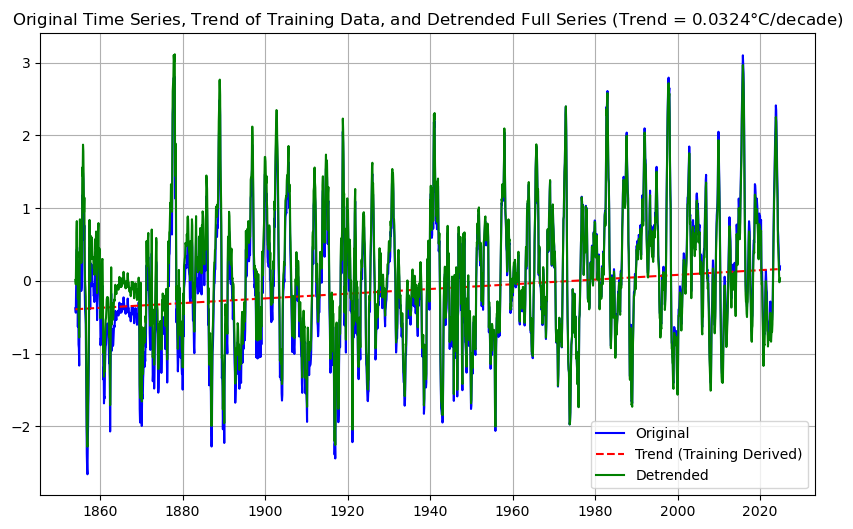

In [7]:
# Convert training time to numeric values for linear regression
time_numeric = np.arange(len(train_data.time))
coeffs = np.polyfit(
    time_numeric, nino34_index.sel(time=slice(train_start, train_end)), 1
)
# time_numeric = np.arange(len(nino34_index.time))
# coeffs = np.polyfit(
#     time_numeric, nino34_index.sel(time=slice(train_start, test_end_y)), 1
# )
slope, intercept = coeffs

# Compute trend over the full dataset
time_numeric_full = np.arange(len(nino34_index.time))
trend = slope * time_numeric_full + intercept

# Remove the trend from the full dataset
nino34_detrended = nino34_index - trend

# Plot detrended index
plt.figure(figsize=(10, 6))
plt.plot(nino34_index.time, nino34_index, label="Original", color="blue")
plt.plot(
    nino34_index.time,
    trend,
    label="Trend (Training Derived)",
    linestyle="--",
    color="red",
)
plt.plot(nino34_index.time, nino34_detrended, label="Detrended", color="green")
# plt.title("Nino 3.4 Index: Original, Trend, and Detrended")
plt.title(
    f"Original Time Series, Trend of Training Data, and Detrended Full Series (Trend = {slope*120:.4f}"  # 12 months * 10 years
    + r"$\degree$C/decade)"
)
plt.legend()
plt.grid()
plt.show()

# 6. Smooth Data

In [8]:
# Apply 5-month rolling mean
nino34_smoothed = nino34_detrended.rolling(time=5, center=False).mean()

# Drop NaNs introduced by rolling mean
nino34_smoothed = nino34_smoothed.dropna(dim="time")

# 7. Shift Data to Account for Lead Time

In [9]:
# Convert to datetime
train_start_date = pd.to_datetime(train_start)
train_end_date = pd.to_datetime(train_end)
val_start_date = pd.to_datetime(val_start)
val_end_date = pd.to_datetime(val_end)
test_start_date = pd.to_datetime(test_start)
test_end_date = pd.to_datetime(test_end)

train_start_date_y = pd.to_datetime(train_start_y)
train_end_date_y = pd.to_datetime(train_end_y)
val_start_date_y = pd.to_datetime(val_start_y)
val_end_date_y = pd.to_datetime(val_end_y)
test_start_date_y = pd.to_datetime(test_start_y)
test_end_date_y = pd.to_datetime(test_end_y)

# Create a new variable that classifies the Nino3.4 index into 3 categories
# 0 = La Nina, 1 = Neutral, 2 = El Nino
nino34_class = xr.DataArray(
    np.where(nino34_smoothed >= 0.5, 2, np.where(nino34_smoothed <= -0.5, 0, 1)),
    coords=[nino34_smoothed.time],
    dims=["time"],
)

print("El Nino samples: ", int(np.sum(nino34_class == 2)))
print("La Nina samples: ", int(np.sum(nino34_class == 0)))
print("Neutral samples: ", int(np.sum(nino34_class == 1)))

# Prepare the data: input is all months except the x-lead last months; output is shifted by the lead
if lead == 0:
    nino34_X = nino34_smoothed
    nino34_Y = nino34_class
else:
    nino34_X = nino34_smoothed[:-lead]
    nino34_Y = nino34_class[
        lead:
    ]  # All but the x-lead month (output is shifted by lead)

# Ensure nino34_X and nino34_Y are the same length and time-aligned
nino34_X["time"] = nino34_X.time.values  # Align nino34_X's time with its original time
nino34_Y["time"] = nino34_Y.time.values  # Ensure nino34_Y has the correct time values

El Nino samples:  564
La Nina samples:  498
Neutral samples:  985


# 8. Create Data Splits for Training, Validation, and Testing

In [10]:
# Create boolean masks to select data by time using the defined periods
train_mask_X = (nino34_X.time >= train_start_date) & (nino34_X.time <= train_end_date)
val_mask_X = (nino34_X.time >= val_start_date) & (nino34_X.time <= val_end_date)
test_mask_X = (nino34_X.time >= test_start_date) & (nino34_X.time <= test_end_date)

train_mask_Y = (nino34_Y.time >= train_start_date_y) & (
    nino34_Y.time <= train_end_date_y
)
val_mask_Y = (nino34_Y.time >= val_start_date_y) & (nino34_Y.time <= val_end_date_y)
test_mask_Y = (nino34_Y.time >= test_start_date_y) & (nino34_Y.time <= test_end_date_y)

# Apply masks to get training, validation, and testing sets (dropping the unmatched time points)
X_train = nino34_X.where(train_mask_X, drop=True)
X_val = nino34_X.where(val_mask_X, drop=True)
X_test = nino34_X.where(test_mask_X, drop=True)

Y_train = nino34_Y.where(train_mask_Y, drop=True)
Y_val = nino34_Y.where(val_mask_Y, drop=True)
Y_test = nino34_Y.where(test_mask_Y, drop=True)

# Can use this for sequential splits with no gaps
# Y_train = nino34_Y[: len(X_train.time)]
# Y_val = nino34_Y[len(X_train.time) : len(X_train.time) + len(X_val.time)]
# Y_test = nino34_Y[len(X_train.time) + len(X_val.time) :]

# Verify shapes
print(f"X_train shape: {X_train.shape}, Y_train shape: {Y_train.shape}")
print(f"X_val shape: {X_val.shape}, Y_val shape: {Y_val.shape}")
print(f"X_test shape: {X_test.shape}, Y_test shape: {Y_test.shape}")

X_train shape: (1511,), Y_train shape: (1511,)
X_val shape: (247,), Y_val shape: (247,)
X_test shape: (278,), Y_test shape: (278,)


# 9. Visualize Data Splits

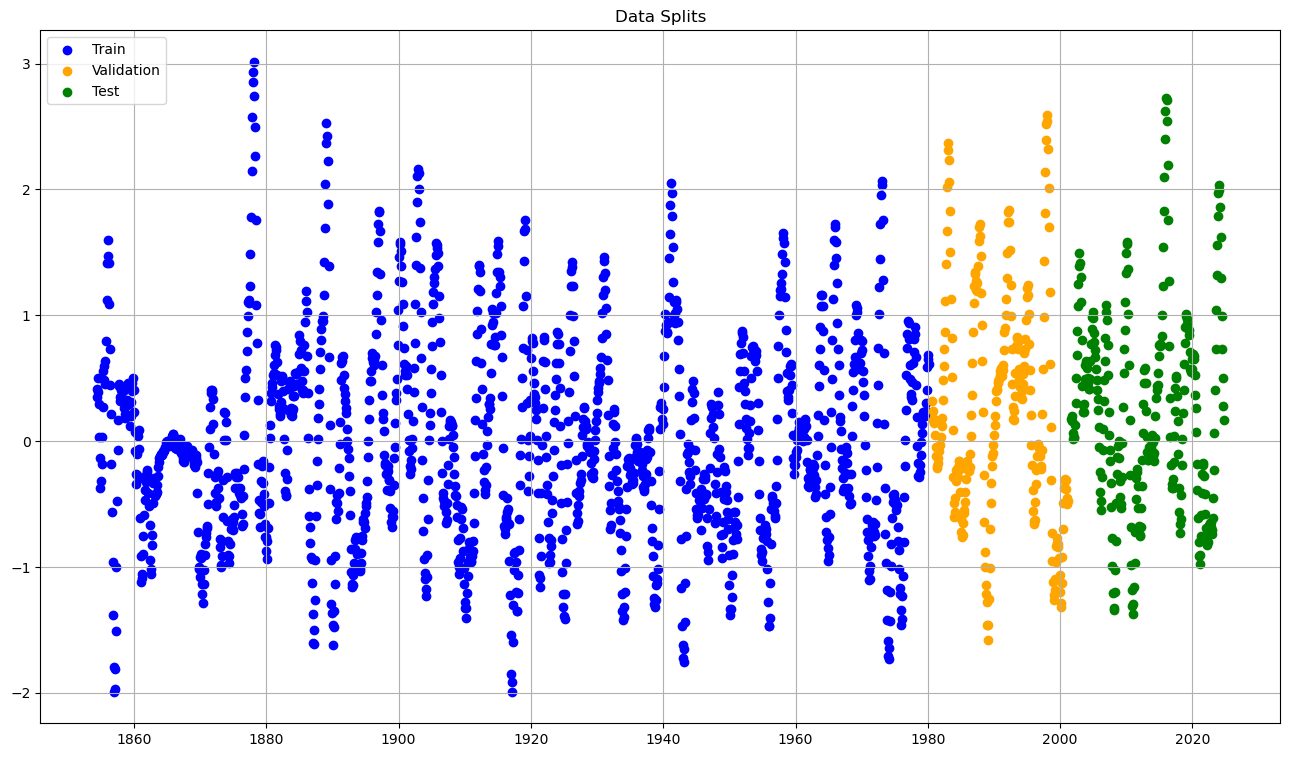

In [11]:
plt.figure(figsize=(16, 9))
plt.scatter(X_train.time, X_train, color="blue", label="Train")
plt.scatter(X_val.time, X_val, color="orange", label="Validation")
plt.scatter(X_test.time, X_test, color="green", label="Test")
plt.title("Data Splits")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# =============================
# 10. Normalize Data
# =============================

# Optional step if you want to "standardize" (aka rescale, normalize) the data

# # Normalize SST data using the training standard deviation (sst_std)
# X_std = np.std(X_train, axis=0)

# # Standardize the train, validation, and test data by dividing by sst_std
# X_train = np.divide(X_train, X_std)
# X_train[np.isnan(X_train)] = 0  # Set NaNs to zero in the training data

# X_val = np.divide(X_val, X_std)
# X_val[np.isnan(X_val)] = 0  # Set NaNs to zero in the validation data

# X_test = np.divide(X_test, X_std)
# X_test[np.isnan(X_test)] = 0  # Set NaNs to zero in the test data

# 11. Convert Data to NumPy for Pytorch use

In [12]:
# Convert xarray DataArray to NumPy arrays using the .values attribute
X_train_np = X_train.values  # Extract NumPy array from xarray DataArray
Y_train_np = Y_train.values  # Similarly for labels

X_val_np = X_val.values
Y_val_np = Y_val.values

X_test_np = X_test.values
Y_test_np = Y_test.values

# Reshape the data to ensure each sample has one feature
X_train_np = X_train_np.reshape(-1, 1)
X_val_np = X_val_np.reshape(-1, 1)
X_test_np = X_test_np.reshape(-1, 1)

print("X and Y training shapes")
print(X_train_np.shape)  # Should be (num_samples, num_features)
print(Y_train_np.shape)  # Should be (num_samples,)

X and Y training shapes
(1511, 1)
(1511,)


# Neural Network Setup

##### The preprocessing of the input and output data is complete. Now, we set up the neural networks to made our predictions.

## Hyperparameter Selection

In [13]:
hiddens = [12, 12]  # Hidden layers: Two layers with 12 nodes each
ridgepen = 1  # L2 regularization (Ridge penalty)
lr = 1e-3  # Learning rate for the optimizer
n_epochs = 250  # Number of epochs to train the model
batch_size = 32  # Batch size for training
# activation = nn.ReLU()  # relu activitation function included in classifier below
output_nodes = 3  # Number of output nodes (three-class for ENSO)
input_size = X_train_np.shape[1]

## Define the network

In [14]:
class ENSOPredictor_Classification(nn.Module):
    def __init__(self, input_size, hidden_layers, output_size):
        super(ENSOPredictor_Classification, self).__init__()
        self.layers = nn.ModuleList()

        # Add the first hidden layer
        self.layers.append(nn.Linear(input_size, hidden_layers[0]))

        # Add additional hidden layers
        for i in range(1, len(hidden_layers)):
            self.layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))

        # Add the output layer
        self.layers.append(nn.Linear(hidden_layers[-1], output_size))

    def forward(self, x):
        # Pass input through each hidden layer with ReLU activation
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        # Output layer with softmax activation
        return torch.softmax(self.layers[-1](x), dim=1)

In [15]:
# Convert numpy arrays (sst and nino data) to PyTorch tensors
train_data = torch.tensor(X_train_np, dtype=torch.float32)  # Feature data for training
train_labels = torch.tensor(
    Y_train_np, dtype=torch.long
)  # Class labels (should be integer-based for classification)

val_data = torch.tensor(X_val_np, dtype=torch.float32)  # Feature data for validation
val_labels = torch.tensor(Y_val_np, dtype=torch.long)  # Validation labels

test_data = torch.tensor(X_test_np, dtype=torch.float32)  # Feature data for testing
test_labels = torch.tensor(Y_test_np, dtype=torch.long)  # Testing labels

# Verify the shapes to ensure correctness
print(train_data.shape)  # Should be (num_samples, 1)
print(train_labels.shape)  # Should be (num_samples,)
print(val_data.shape)  # Should be (num_samples, 1)
print(val_labels.shape)  # Should be (num_samples,)
print(test_data.shape)  # Should be (num_samples, 1)
print(test_labels.shape)  # Should be (num_samples,)

# To store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

torch.Size([1511, 1])
torch.Size([1511])
torch.Size([247, 1])
torch.Size([247])
torch.Size([278, 1])
torch.Size([278])


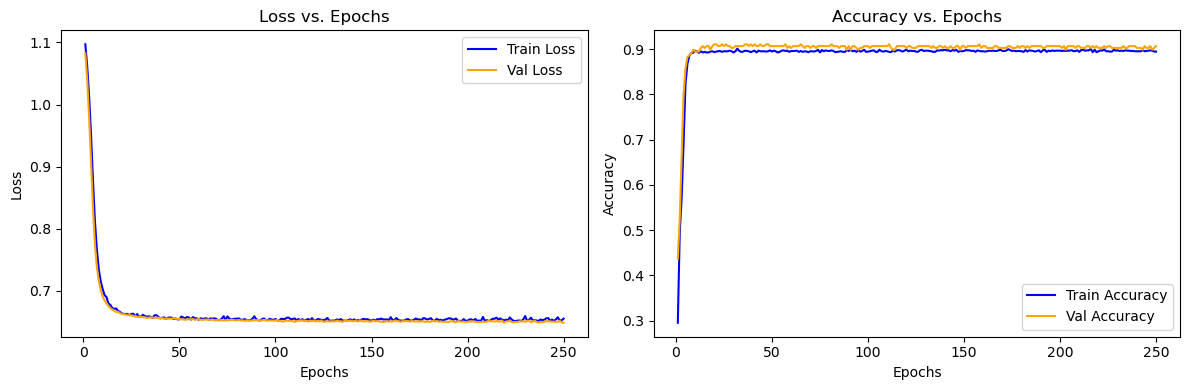

In [16]:
# Instantiate the model with the specified parameters
model = ENSOPredictor_Classification(input_size, hiddens, output_nodes)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.Adam(
    model.parameters(), lr=lr
)  # Adam optimizer with L2 regularization

# Create DataLoader without modifying the original dataset
# DataLoaders are helpful for batching to streamline the process of feeding data into the model
train_dataset = TensorDataset(train_data, train_labels)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(val_data, val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training loop
for epoch in range(n_epochs):
    model.train()
    running_loss = (
        0.0  # Store variables to comput loss and accuracy as a function of epoch
    )
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        outputs = model(inputs)  #  Make predictions for current batch of inputs
        loss = criterion(
            outputs, labels
        )  #  Calculate loss based on predictions and actual labels

        optimizer.zero_grad()  #  Zero out the gradients from the previous iteration
        loss.backward()  #  Backpropagate the loss
        optimizer.step()  #  Update the model parameters based on the gradients

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)  #  Get the predicted class labels
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(running_loss / len(train_loader))
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += (
                loss.item()
            )  #  Accumulate the validation loss to compute avrage validation loss
            _, predicted = torch.max(outputs, 1)  #  Get the predicted class labels
            total_val += labels.size(0)  #  Accumulate the total number of samples
            correct_val += (
                (predicted == labels).sum().item()
            )  #  Accumulate the number of correct predictions

    val_losses.append(val_loss / len(val_loader))
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    # print(f'Epoch {epoch+1}/{n_epochs}, Loss: {loss.item()}, Val Loss: {val_loss/len(val_loader)}, Val Accuracy: {correct/total}')

# Plotting Loss and Accuracy

# Create a 1x2 subplot for loss and accuracy
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot Loss
axs[0].plot(range(1, n_epochs + 1), train_losses, label="Train Loss", color="blue")
axs[0].plot(range(1, n_epochs + 1), val_losses, label="Val Loss", color="orange")
axs[0].set_title("Loss vs. Epochs")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()

# Plot Accuracy
axs[1].plot(
    range(1, n_epochs + 1), train_accuracies, label="Train Accuracy", color="blue"
)
axs[1].plot(
    range(1, n_epochs + 1), val_accuracies, label="Val Accuracy", color="orange"
)
axs[1].set_title("Accuracy vs. Epochs")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend()

plt.tight_layout()
plt.show()

## Evaluate Model on Test Data

In [17]:
#  We want to retain the original indices of the test data for extracting predictions for composites

test_dataset = TensorDataset(test_data, test_labels)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize variables
correct = 0
total = 0
correct_predictions_indices = []  # Store the indices of correct predictions

# Evaluation phase for test data
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    for batch_idx, (inputs, labels) in enumerate(test_loader):
        # Get predictions
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get the predicted class

        # Calculate the number of correct predictions
        correct_predictions = predicted == labels

        # Accumulate correct predictions and total samples
        correct += correct_predictions.sum().item()
        total += labels.size(0)

        # Calculate the start index for this batch
        start_idx = batch_idx * batch_size

        # Collect the indices of correct predictions
        correct_indices = torch.arange(start_idx, start_idx + len(predicted))[
            correct_predictions
        ]
        correct_predictions_indices.extend(
            correct_indices.tolist()
        )  # Extend the list with correct indices

# Convert the list of correct indices to a torch tensor
correct_predictions_indices = torch.tensor(correct_predictions_indices)

# Get times of correct predictions (if needed)
correct_times = Y_test.time[correct_predictions_indices]

# Calculate test accuracy
test_accuracy = correct / total
print(f"Test Accuracy: {test_accuracy:.2%}")  # Print as percentage

Test Accuracy: 87.41%


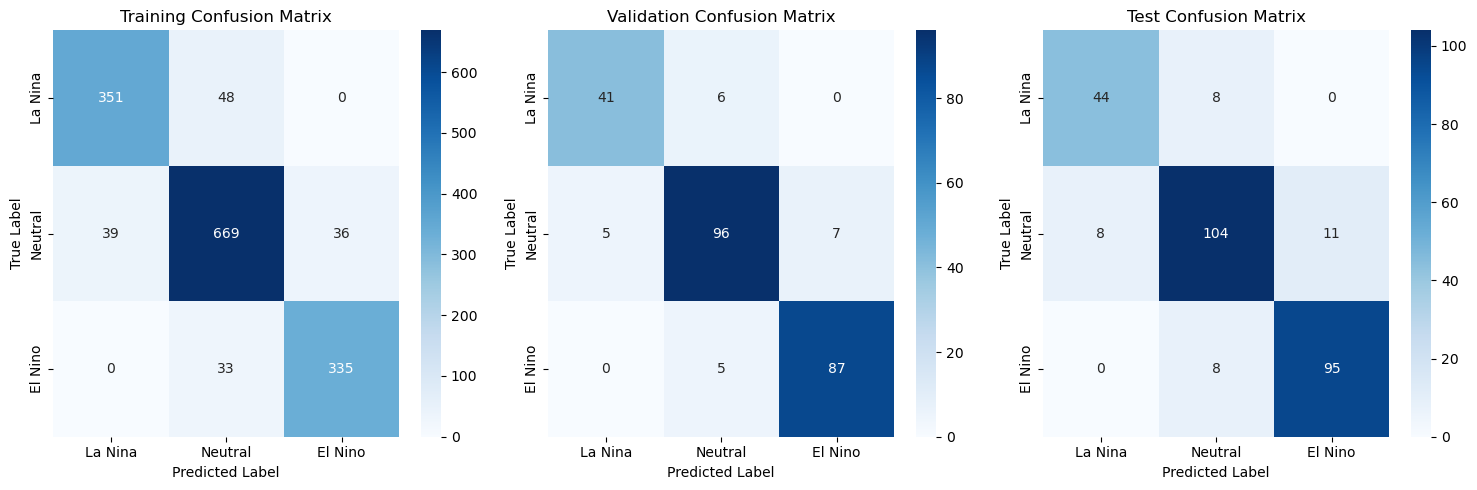

In [18]:
# Function to compute predictions and confusion matrix
def get_confusion_matrix(loader, model):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    # Concatenate all predictions and labels
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Compute confusion matrix
    return confusion_matrix(all_labels, all_preds)


# Generate confusion matrices for training, validation, and test sets
train_confusion_matrix = get_confusion_matrix(train_loader, model)
val_confusion_matrix = get_confusion_matrix(val_loader, model)
test_confusion_matrix = get_confusion_matrix(test_loader, model)

# Plot confusion matrices side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Define class labels
class_names = ["La Nina", "Neutral", "El Nino"]

# Plot for training confusion matrix
sns.heatmap(
    train_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axs[0],
)
axs[0].set_title("Training Confusion Matrix")
axs[0].set_xlabel("Predicted Label")
axs[0].set_ylabel("True Label")

# Plot for validation confusion matrix
sns.heatmap(
    val_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axs[1],
)
axs[1].set_title("Validation Confusion Matrix")
axs[1].set_xlabel("Predicted Label")
axs[1].set_ylabel("True Label")

# Plot for test confusion matrix
sns.heatmap(
    test_confusion_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
    ax=axs[2],
)
axs[2].set_title("Test Confusion Matrix")
axs[2].set_xlabel("Predicted Label")
axs[2].set_ylabel("True Label")

# Display the plot
plt.tight_layout()
plt.show()
# plt.savefig(f"../figs/confusion_matrices_{exp_name}.png", dpi=300)

## Plot Composites to help understand network predictions

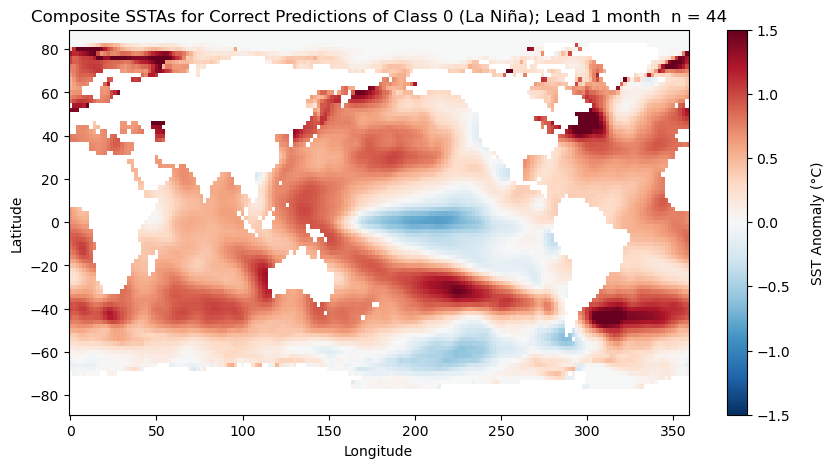

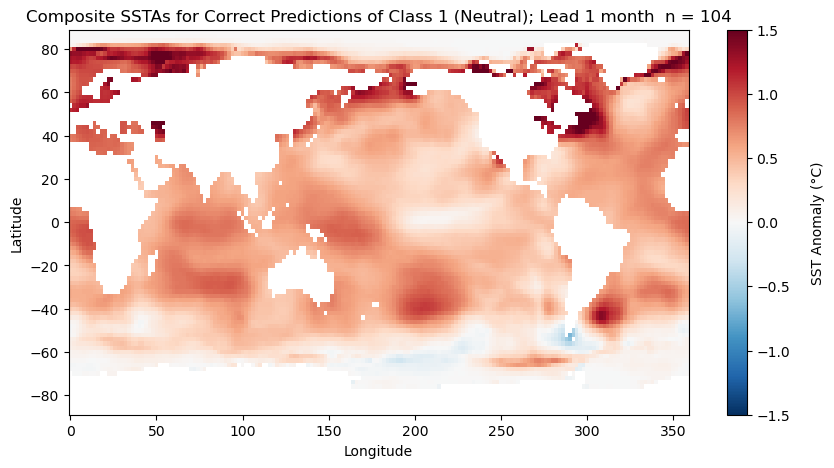

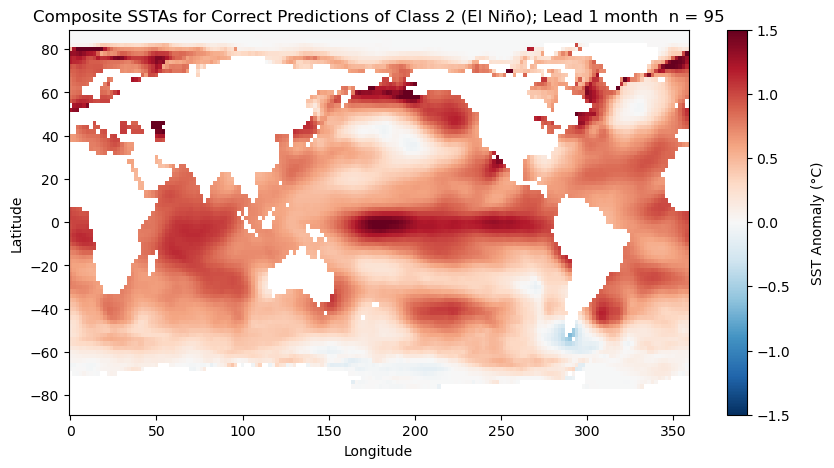

In [20]:
test_labels_tensor = (
    test_labels.clone().detach()
)  # Clone and detach to avoid gradient tracking to convert test_labels to a tensor

# Extract indices for each class based on correct predictions
correct_class_0_indices = correct_predictions_indices[
    test_labels_tensor[correct_predictions_indices] == 0
]  # La Niña
correct_class_1_indices = correct_predictions_indices[
    test_labels_tensor[correct_predictions_indices] == 1
]  # Neutral
correct_class_2_indices = correct_predictions_indices[
    test_labels_tensor[correct_predictions_indices] == 2
]  # El Niño

# Create a custom diverging colormap with white in the middle
cmap = mcolors.TwoSlopeNorm(vmin=-1.5, vcenter=0, vmax=1.5)
custom_cmap = "RdBu_r"


# Function to generate composites for a specific class
def composite_plot(class_indices, class_label, tos_nino34, nino_test):
    # Get the timestamps corresponding to the correct predictions for the specified class
    correct_times = nino_test.time[
        class_indices
    ]  # Adjust according to your time variable

    # Create a mask to select SST data based on correct prediction timestamps
    mask = tos_nino34.time.isin(correct_times)

    # Composite the SST data for the correct predictions of the specified class
    composite_sst = tos_nino34.where(mask, drop=True).mean(dim="time")

    # Plotting the composite SST for the correct predictions of the specified class
    plt.figure(figsize=(10, 5))
    mappable = composite_sst.plot(
        cmap=custom_cmap, norm=cmap, robust=True, add_colorbar=False
    )  # Use the custom colormap

    # Adding colorbar and setting the label
    cbar = plt.colorbar(mappable)
    cbar.set_label(
        "SST Anomaly (°C)", rotation=90, labelpad=15
    )  # Rotate the label and set padding

    plt.title(
        f"Composite SSTAs for Correct Predictions of Class {class_label}"
        + "  n = "
        + str(len(class_indices))
    )
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


# Generate composites for all three classes
composite_plot(
    correct_class_0_indices,
    "0 (La Niña); Lead " + str(lead) + " month",
    sst_anomalies,
    Y_test,
)
composite_plot(
    correct_class_1_indices,
    "1 (Neutral); Lead " + str(lead) + " month",
    sst_anomalies,
    Y_test,
)
composite_plot(
    correct_class_2_indices,
    "2 (El Niño); Lead " + str(lead) + " month",
    sst_anomalies,
    Y_test,
)